# Practice: Clustering

## 1. Import Libary & Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering\
    , DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer

from scipy.cluster.hierarchy import dendrogram

In [2]:
df = pd.read_csv("Data/marketing_campaign.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


## 2. Explore Data

In [3]:
# Rename Columns
df.rename(mapper=lambda x: x.title(), axis=1, inplace=True)

# Check nulls
print("Null Value Count:", df.isnull().sum().sum())
print()

# Check duplicates
print("Duplicate Row Count:", df.duplicated().sum())
print()

# Drop Duplicates & Unneeded Columns
df_backup = df.copy()
df.drop_duplicates(keep="first", inplace=True)
df.drop(columns=['Z_Costcontact', 'Z_Revenue'], inplace=True)
print("Dropped Duplicate:", df_backup.shape[0] - df.shape[0])
print("New Data Dimension:", df.shape)

Null Value Count: 0

Duplicate Row Count: 184

Dropped Duplicate: 184
New Data Dimension: (2021, 37)


In [63]:
numerical_col = ['Income', 'Recency', 'Mntwines', 'Mntfruits',
       'Mntmeatproducts', 'Mntfishproducts', 'Mntsweetproducts',
       'Mntgoldprods', 'Numdealspurchases', 'Numwebpurchases',
       'Numcatalogpurchases', 'Numstorepurchases', 'Numwebvisitsmonth', 
       'Age', 'Customer_Days',
       'Mnttotal', 'Mntregularprods','Acceptedcmpoverall', 'Kidhome', 'Teenhome']
display(df[numerical_col].describe())

categorical_col = [i for i in df.columns.to_list() if i not in numerical_col]
display(df[categorical_col].describe())

,Income,Recency,Mntwines,Mntfruits,Mntmeatproducts,Mntfishproducts,Mntsweetproducts,Mntgoldprods,Numdealspurchases,Numwebpurchases,Numcatalogpurchases,Numstorepurchases,Numwebvisitsmonth,Age,Customer_Days,Mnttotal,Mntregularprods,Acceptedcmpoverall,Kidhome,Teenhome
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,51687.258783,48.880752,306.492331,26.364671,166.059871,37.603662,27.268679,43.921821,2.330035,4.115289,2.644730,5.807521,5.340426,51.117269,2511.613063,563.789213,519.867392,0.302326,0.443345,0.509649
std,20713.046401,28.950917,337.603877,39.776518,219.869126,54.892196,41.575454,51.678211,1.892778,2.753588,2.799126,3.230434,2.426319,11.667616,202.546762,576.775749,554.797857,0.680812,0.536196,0.546393
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,2159.000000,4.000000,-283.000000,0.000000,0.000000,0.000000
25%,35416.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,43.000000,2337.000000,55.000000,42.000000,0.000000,0.000000,0.000000
50%,51412.000000,49.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,2.000000,5.000000,6.000000,50.000000,2511.000000,343.000000,288.000000,0.000000,0.000000,0.000000
75%,68274.000000,74.000000,507.000000,33.000000,230.000000,50.000000,34.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,61.000000,2688.000000,964.000000,883.000000,0.000000,1.000000,1.000000
max,113734.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,80.000000,2858.000000,2491.000000,2458.000000,4.000000,2.000000,2.000000


,Acceptedcmp3,Acceptedcmp4,Acceptedcmp5,Acceptedcmp1,Acceptedcmp2,Complain,Response,Marital_Divorced,Marital_Married,Marital_Single,Marital_Together,Marital_Widow,Education_2N Cycle,Education_Basic,Education_Graduation,Education_Master,Education_Phd
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,0.074715,0.076695,0.072241,0.065809,0.012865,0.009401,0.153884,0.105888,0.388422,0.219198,0.251856,0.034636,0.090549,0.024245,0.502227,0.165760,0.217219
std,0.262997,0.266172,0.258951,0.248009,0.112720,0.096527,0.360927,0.307771,0.487512,0.413806,0.434186,0.182902,0.287038,0.153848,0.500119,0.371957,0.412455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/opt/miniconda3/envs/myenv_practice/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/miniconda3/envs/myenv_practice/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


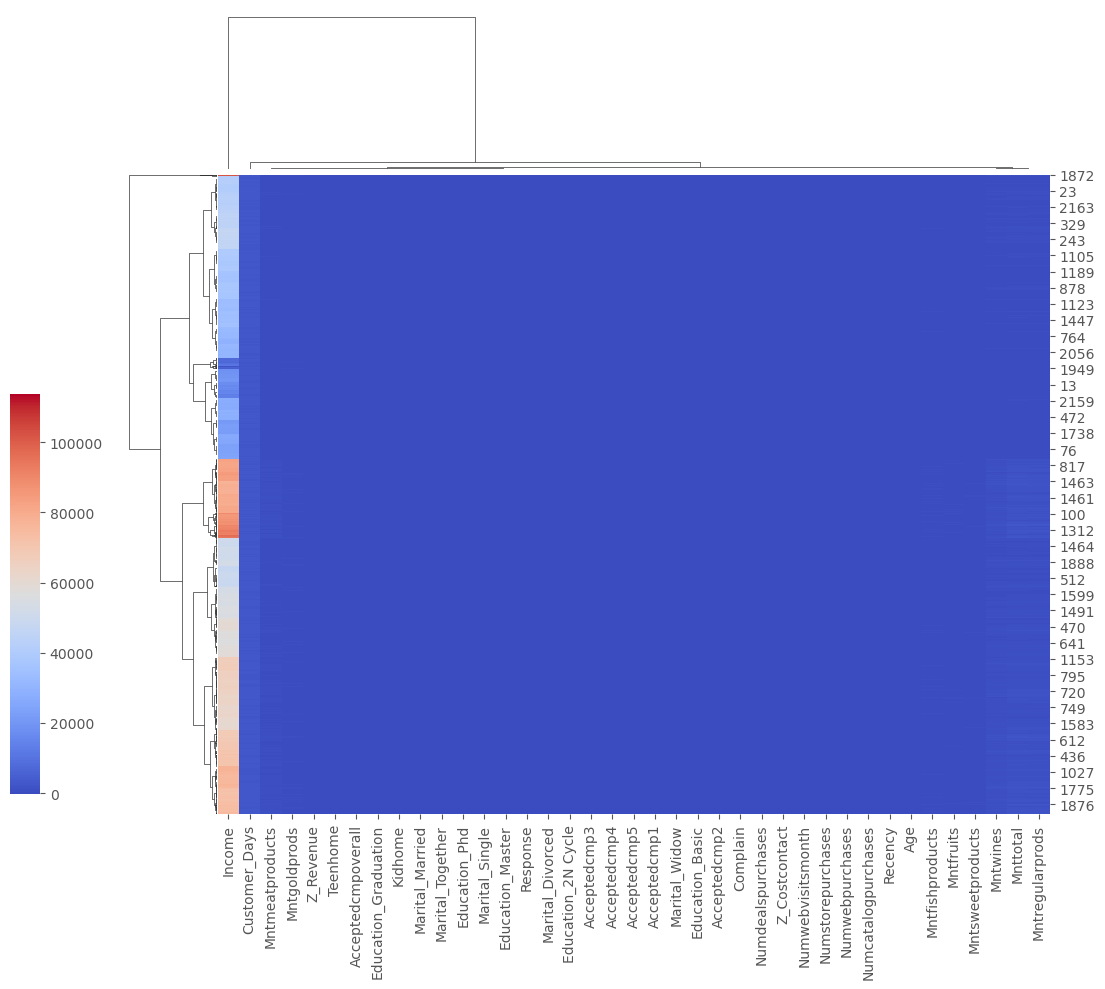

In [ ]:
plt.style.use('ggplot')
g = sns.clustermap(df, 
                method= "centroid",
                dendrogram_ratio=(0.1,0.2), 
                cbar_pos=(-0.1, .2, .03, .4),
                cmap = "coolwarm")
plt.show()

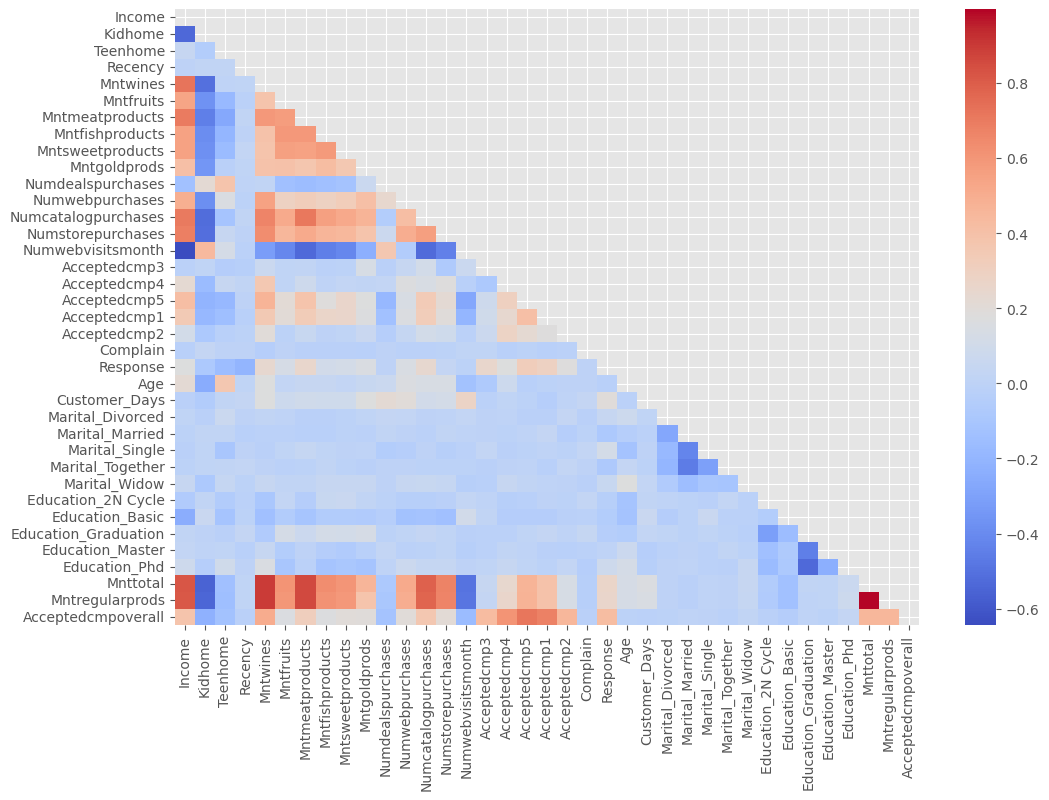

In [41]:
sns.heatmap(df.corr(), mask=np.triu(np.ones((df.shape[1],df.shape[1]))), cmap="coolwarm")
plt.show()

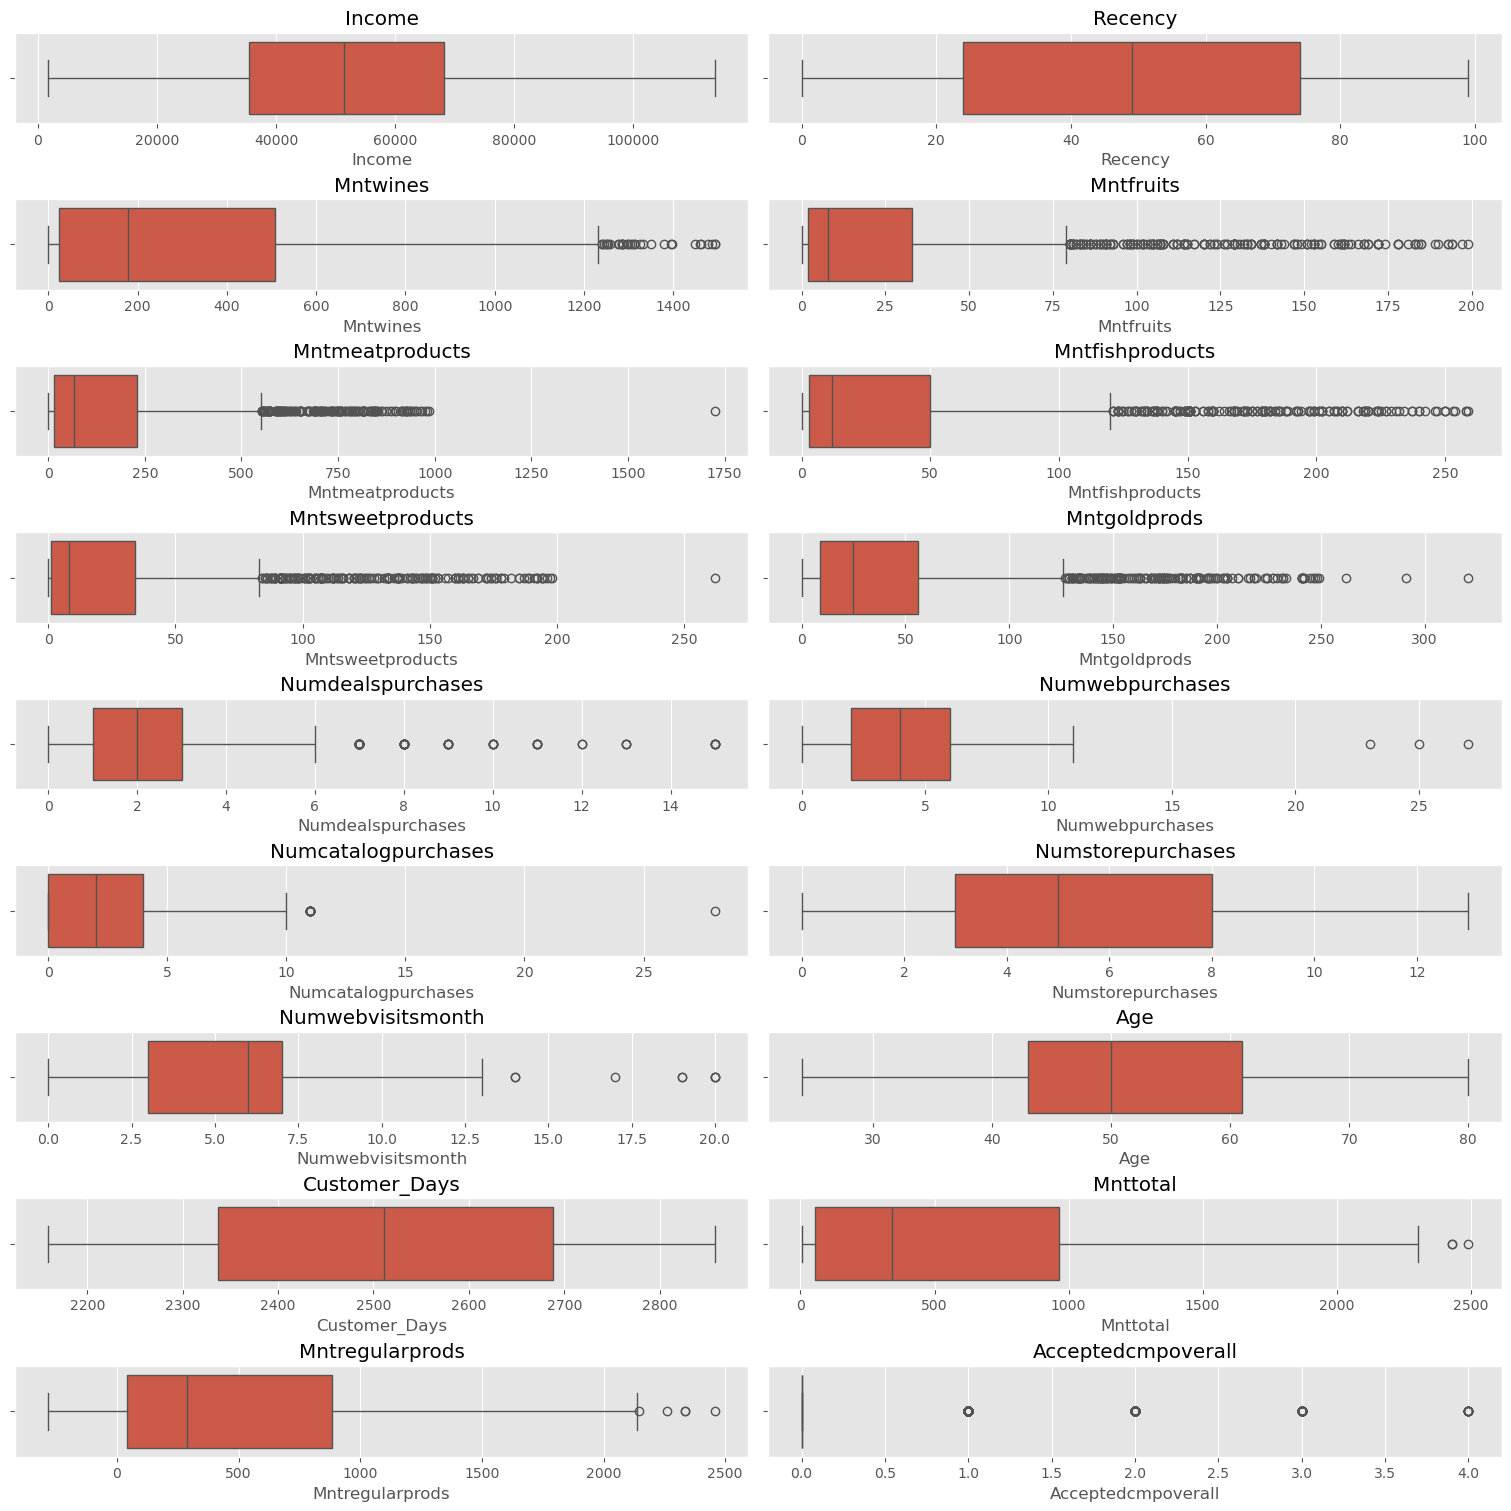

In [44]:
fig, axes = plt.subplots(nrows= int(round(len(numerical_col)/2,0)),
                        ncols=2,
                        layout = "constrained",
                        figsize = (15,15))
axes = axes.ravel()
for i, col in enumerate(numerical_col):
    sns.boxplot(df, x = col, ax = axes[i])
    axes[i].set_title(f"{col}")
plt.show()

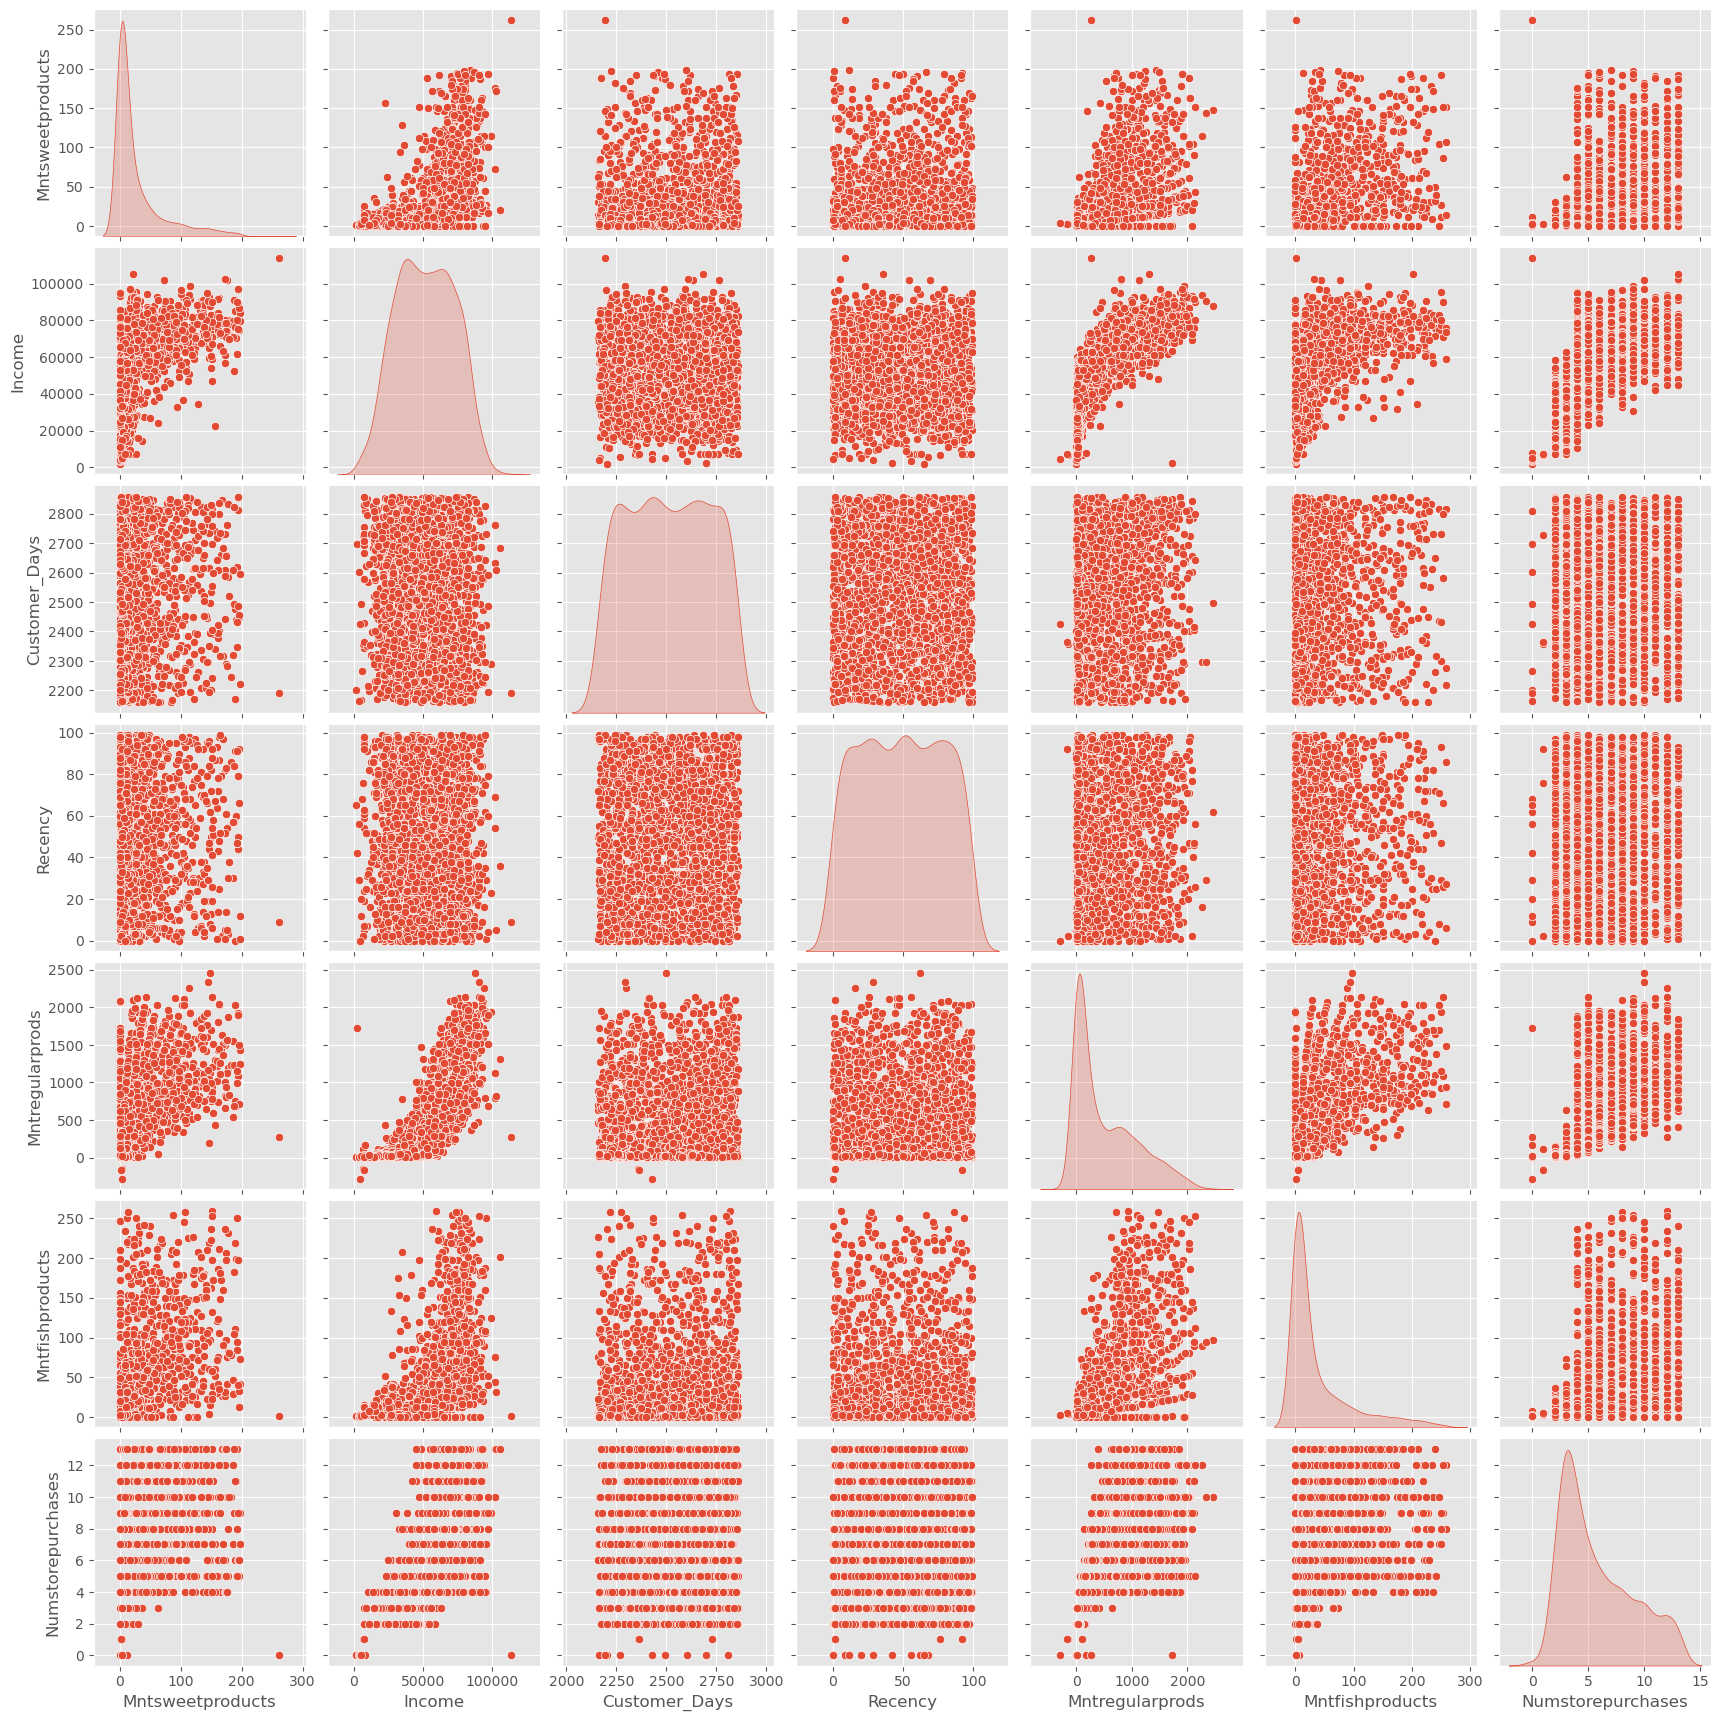

In [47]:
np.random.seed(207)
sns.pairplot(df, vars=np.random.choice(numerical_col,7), diag_kind='kde')
plt.show()

## 3. Fit Cluster Model
### 3.1. Determine number of Clusters with Elbow Method

In [64]:
preprocessing = ColumnTransformer(transformers=[
    ("scaler",StandardScaler(),numerical_col)
], remainder="passthrough", verbose_feature_names_out=False)
X = preprocessing.fit_transform(df)

In [65]:
wcss = { 'Number of Clusters':[], 'WCSS Score':[]}
for i in range(1,21,1):
    kmeans = KMeans(i, random_state=208)
    kmeans.fit(X)
    wcss['WCSS Score'].append(kmeans.inertia_)
    wcss['Number of Clusters'].append(i)
wcss_df = pd.DataFrame(wcss)
wcss_df["WCSS Gains"] = -(wcss_df["WCSS Score"] / wcss_df["WCSS Score"].shift(1) - 1)
wcss_df

,Number of Clusters,WCSS Score,WCSS Gains
0,1,44078.457199,NaN
1,2,30730.316483,0.302827
2,3,27377.251018,0.109113
3,4,26013.476408,0.049814
4,5,25219.967126,0.030504
5,6,23935.307219,0.050938
6,7,23178.538746,0.031617
7,8,22462.860229,0.030877
8,9,22056.049811,0.018110
9,10,21636.812042,0.019008


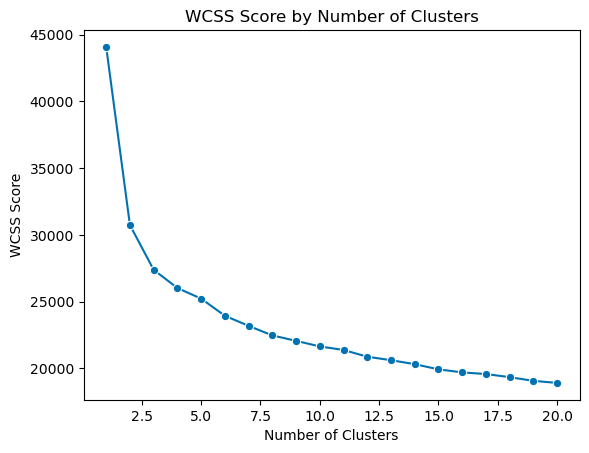

In [66]:
plt.style.use('seaborn-v0_8-colorblind')
ax = sns.lineplot(wcss_df, x="Number of Clusters", y ="WCSS Score",
                  marker="o")
ax.set_title("WCSS Score by Number of Clusters")
plt.show()

In [71]:
kmeans = KMeans(n_clusters=3, random_state=208)
kmeans_class_labels = kmeans.fit_predict(X)
results_df = df.copy()
results_df["K-Means_Predict"] = kmeans_class_labels
silh_score = silhouette_score(X, kmeans_class_labels, random_state=0)
print(f"Silhouette score: {silh_score:0.3f}")

Silhouette score: 0.206


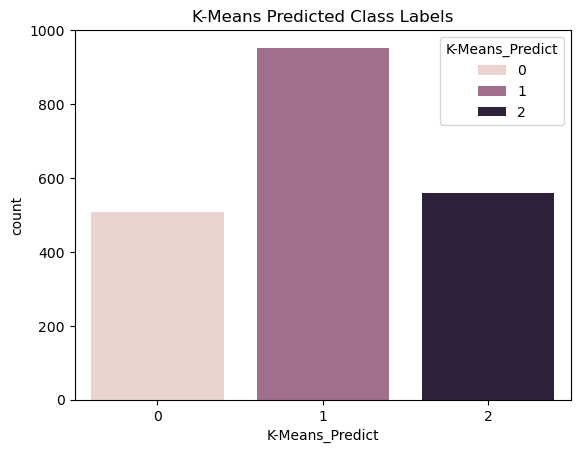

In [72]:
ax = sns.countplot(results_df, 
                   x = "K-Means_Predict", hue="K-Means_Predict")
ax.set_title("K-Means Predicted Class Labels")
ax.set
plt.show()

In [74]:
dbscan = DBSCAN(eps=5, min_samples=2, metric="euclidean")
dbscan_class_labels = dbscan.fit_predict(X)
results_df["DBSCAN_Predict"] = dbscan_class_labels
silh_score = silhouette_score(X, dbscan_class_labels, random_state=207)
print(f"Silhouette score: {silh_score:0.3f}")

Silhouette score: 0.372


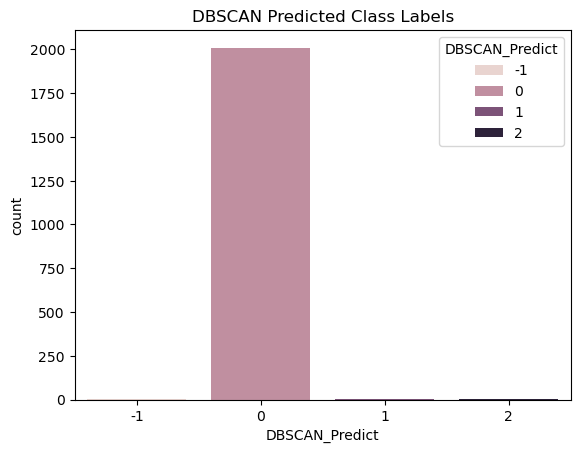

In [75]:
ax = sns.countplot(results_df, x = "DBSCAN_Predict", hue="DBSCAN_Predict")
ax.set_title("DBSCAN Predicted Class Labels")
ax.set
plt.show()

## 4. Examine K-Means Results

In [ ]:
results_df.pivot_table(values=numerical_col, 
                       columns="K-Means_Predict", aggfunc="mean")

K-Means_Predict,0,1,2
Acceptedcmpoverall,0.750491,0.087924,0.257042
Age,51.895874,48.472458,54.815141
Customer_Days,2525.642436,2474.620763,2560.521127
Income,76420.043222,34726.676907,57711.558099
Mntfishproducts,100.943026,6.790254,32.054577
Mntfruits,69.330059,4.935381,23.477113
Mntgoldprods,76.772102,15.435381,61.827465
Mntmeatproducts,465.844794,22.936441,135.281690
Mntregularprods,1277.986248,68.119703,591.288732
Mntsweetproducts,72.055010,5.063559,24.038732


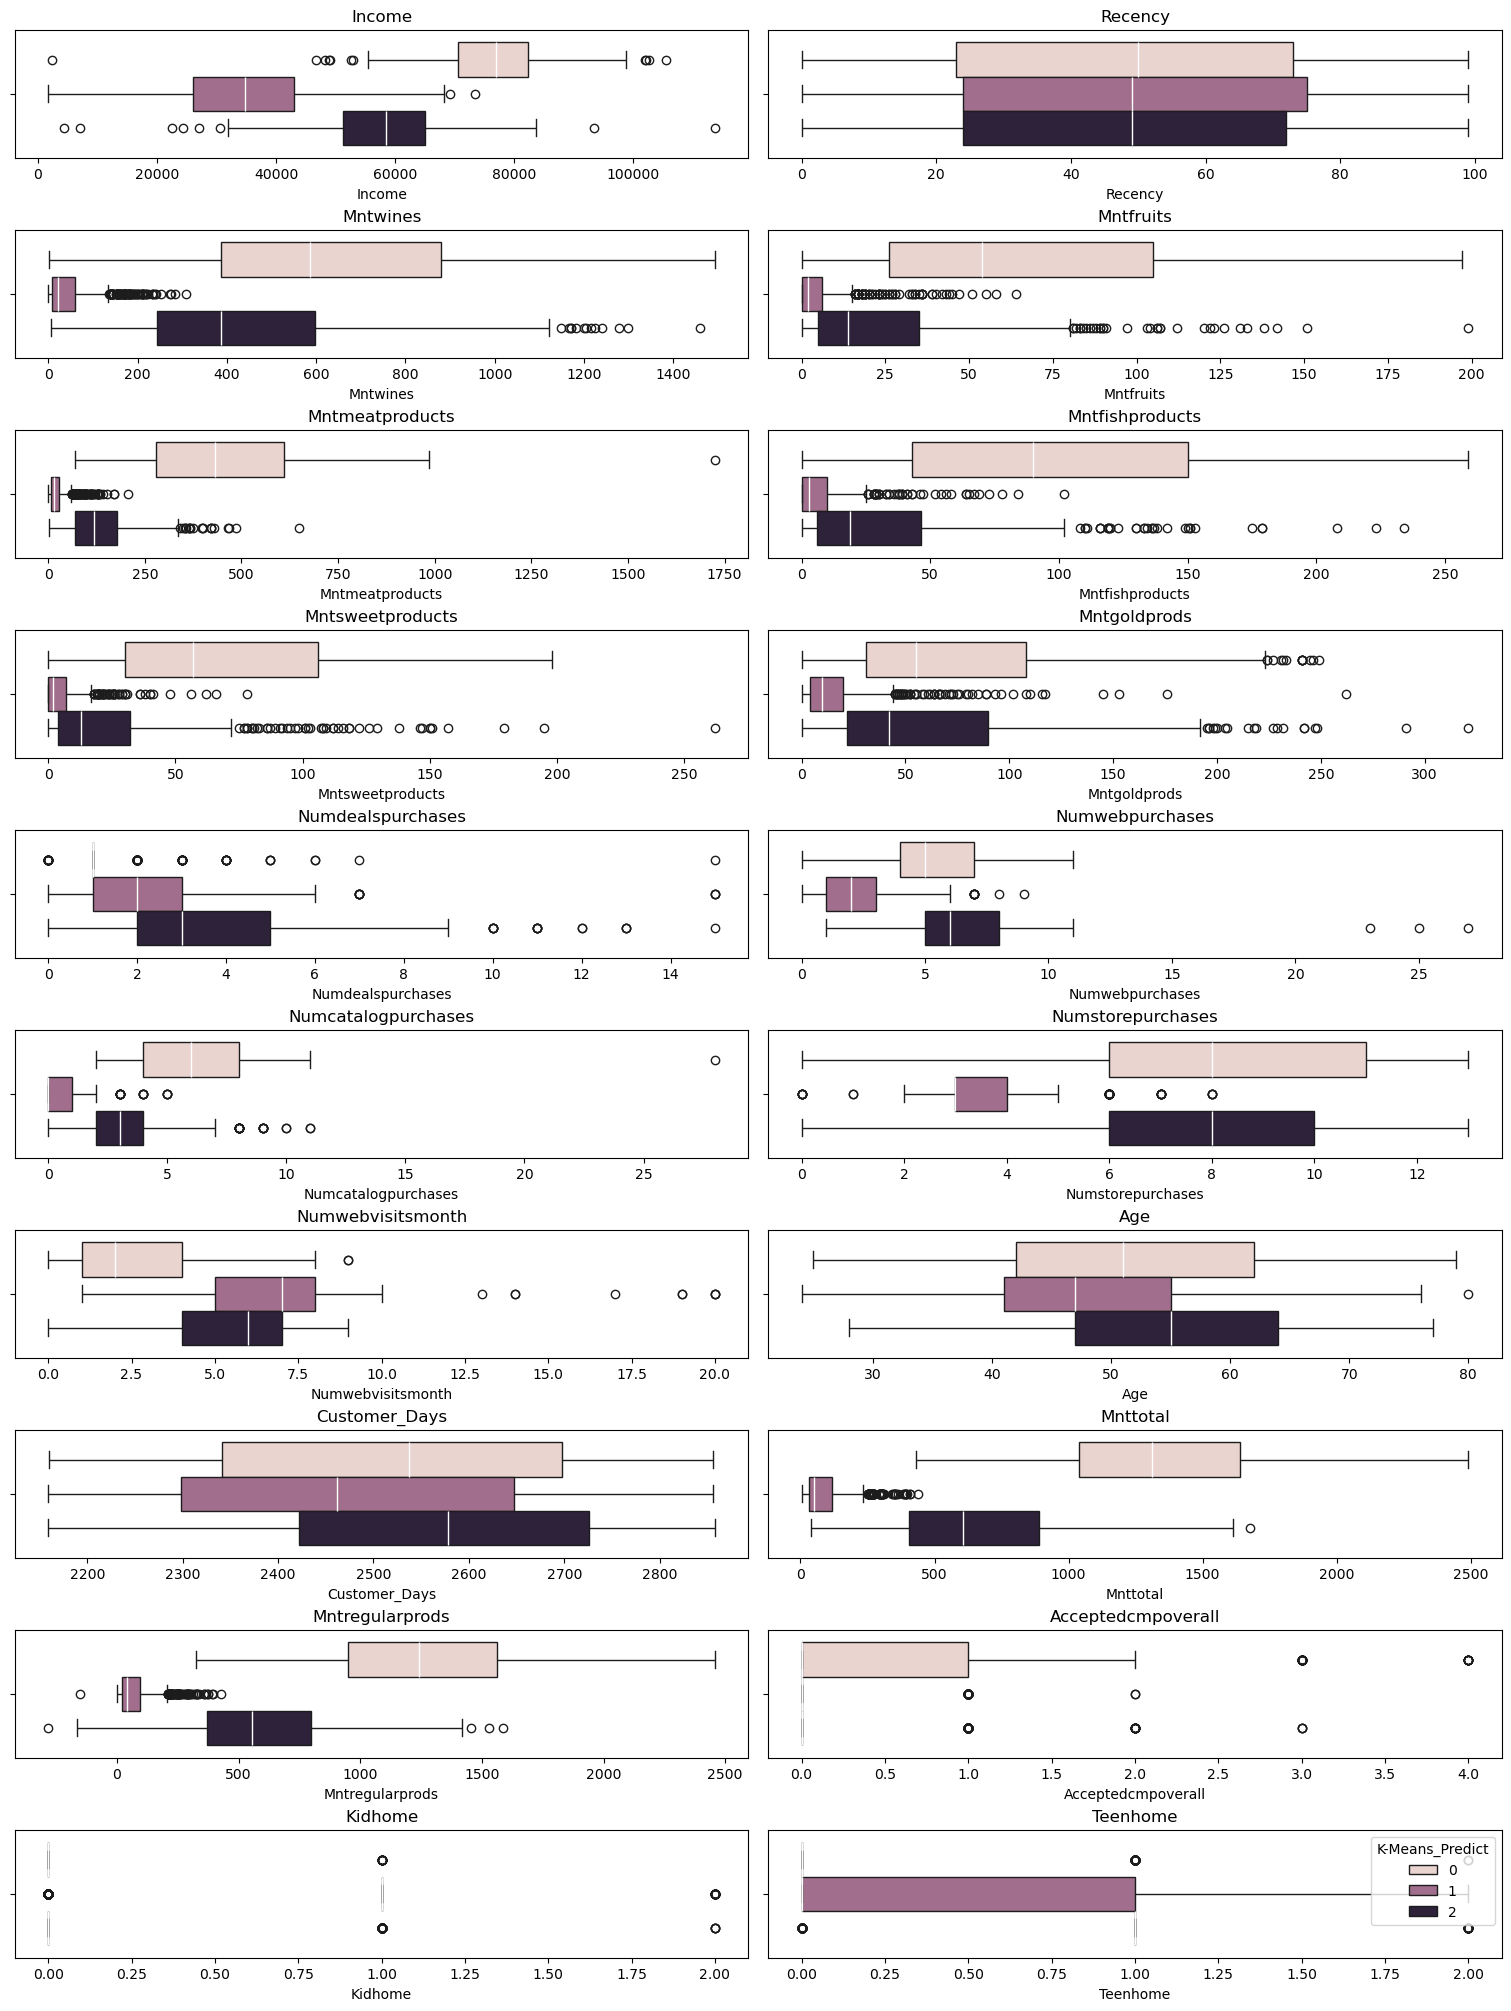

In [76]:
fig, axes = plt.subplots(nrows= int(round(len(numerical_col)/2,0)),
                        ncols=2,
                        layout = "constrained",
                        figsize = (15,20))
axes = axes.ravel()
for i, col in enumerate(numerical_col):
    sns.boxplot(results_df, x = col, ax = axes[i],
                legend= (i==len(numerical_col)-1),
                medianprops=dict(color="white", alpha=1),
                hue="K-Means_Predict")
    axes[i].set_title(f"{col}")
plt.show()

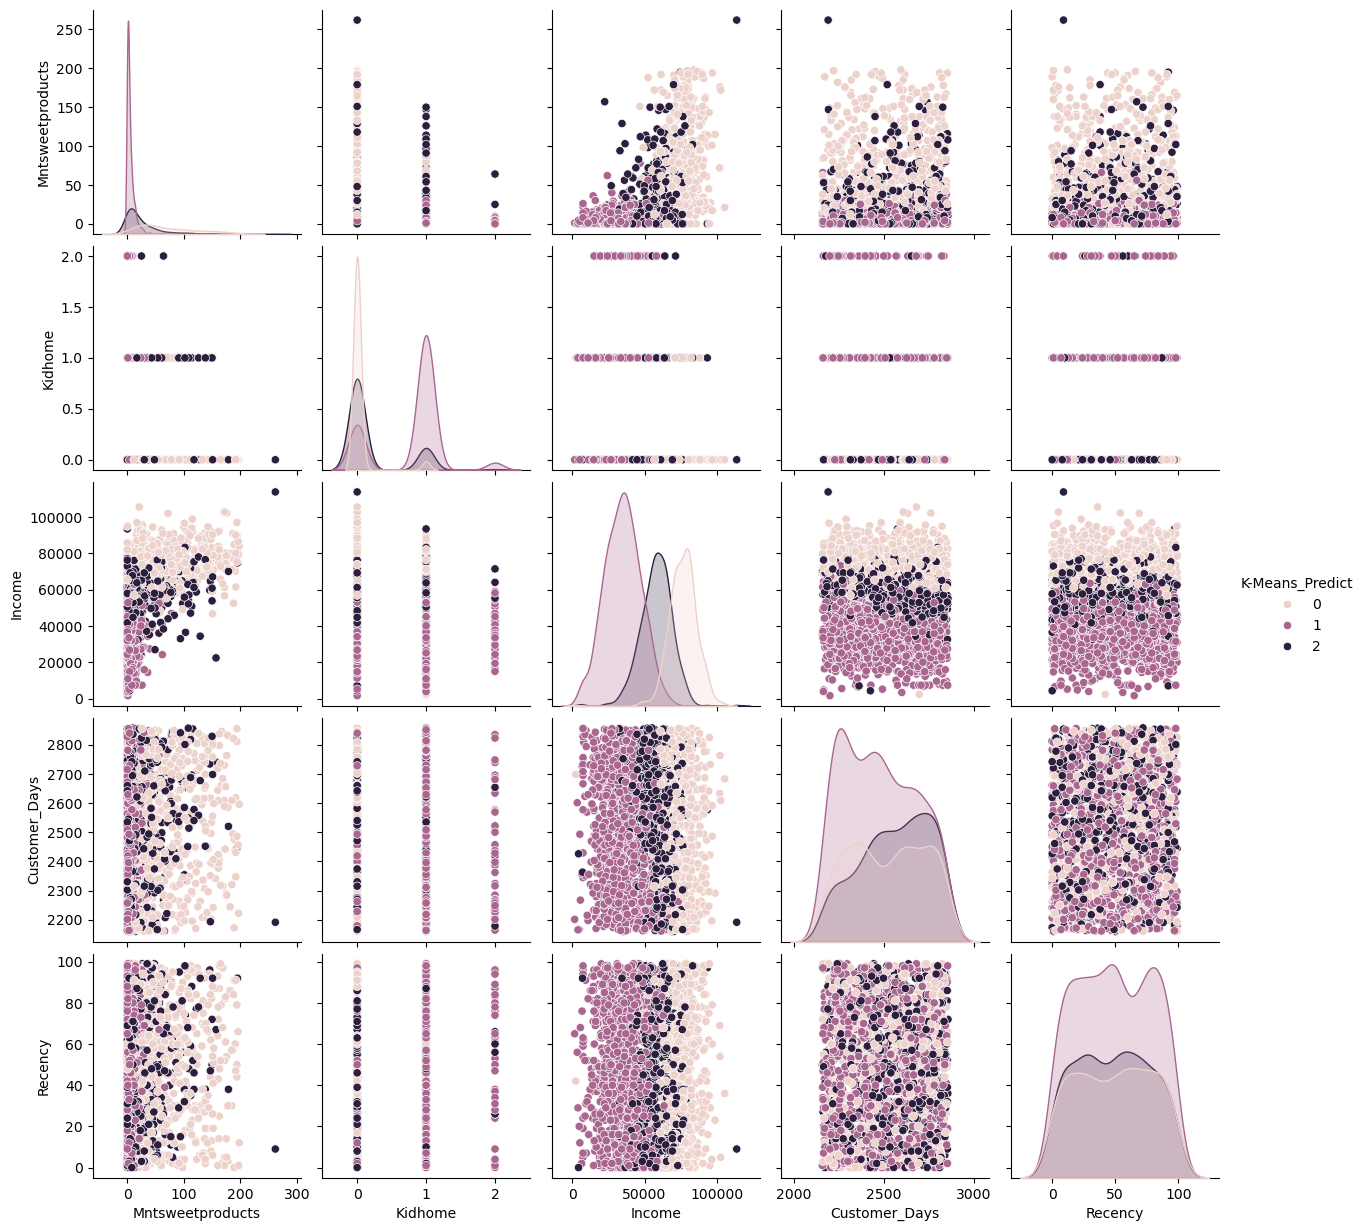

In [77]:
np.random.seed(207)
sns.pairplot(results_df, vars=np.random.choice(numerical_col,5), 
             diag_kind='kde', hue="K-Means_Predict")
plt.show()

In [79]:
def coalesce_multinomial_col(results_df, category):
    for col in [i for i in categorical_col if category in i]:
        cat_label = col.split(sep="_")[1]
        results_df[f"Temp_{col}"] = results_df[col].apply(lambda x: cat_label if x==1 else np.nan)
    results_df[category] = results_df.loc[:, results_df.columns.str.match('^Temp')].bfill(axis=1).iloc[:, 0]
    results_df.drop(columns= [i for i in results_df.columns.to_list() if "Temp_" in i] ,inplace=True)
for category in ["Marital","Education"]:
    coalesce_multinomial_col(results_df,category)
    display(results_df[category].value_counts())

Marital
Married     785
Together    509
Single      443
Divorced    214
Widow        70
Name: count, dtype: int64

Education
Graduation    1015
Phd            439
Master         335
2N Cycle       183
Basic           49
Name: count, dtype: int64

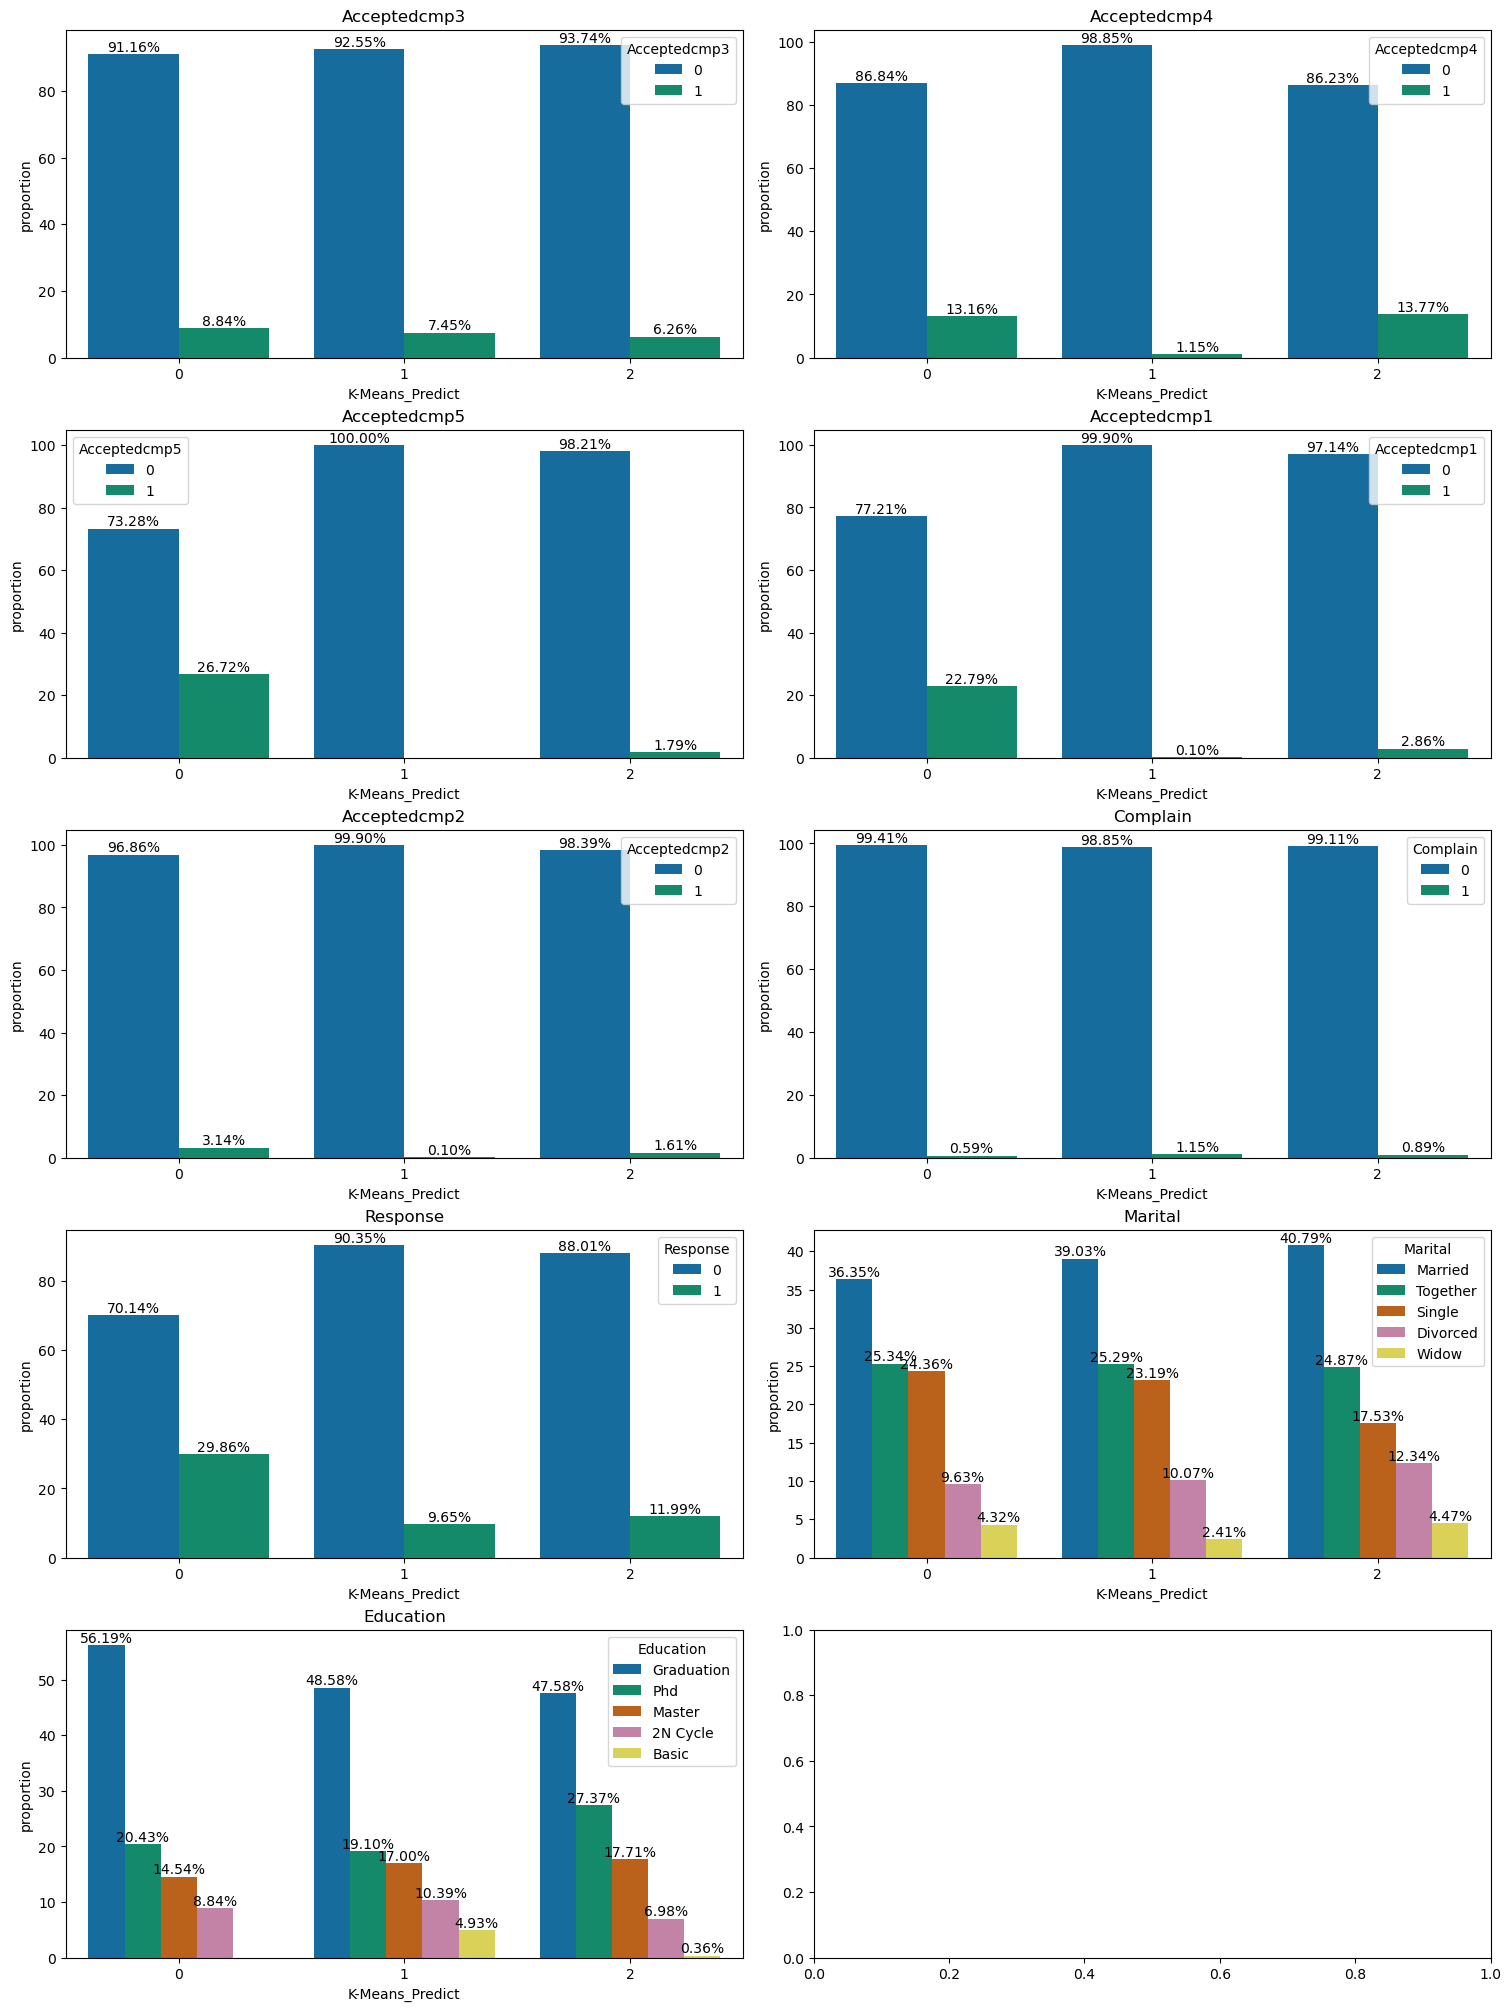

In [89]:
fig, axes = plt.subplots(nrows=5, ncols=2,
                       layout = "constrained",
                        figsize = (15,20))
axes = axes.ravel()
for i, col in enumerate(categorical_col[0: categorical_col.index('Marital_Divorced')] + ["Marital","Education"]):
    temp_df = results_df.groupby(["K-Means_Predict"])[col].value_counts(normalize=True)\
                    .mul(100).round(2).reset_index()
    sns.barplot(temp_df, x="K-Means_Predict", y = "proportion",
                    ax=axes[i],
                    hue=col)
    axes[i].set_title(col)
    for bar in axes[i].containers:
        axes[i].bar_label(bar, fmt =  lambda v: f"{v:.2f}%")
plt.show()
